In [1]:
import tensorflow as tf
import h5py 
import matplotlib.pyplot as plt
import numpy as np
import timeit
from sklearn import preprocessing

/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# batched data generating function

In [2]:
def batch_generator(filename, batch_size):
    f = h5py.File(filename, 'r')
    batch_count = 0
    while True:
        if batch_count * batch_size + batch_size > f['label'].shape[0]: #若batchsize不能整除的話，最後餘下的資料永遠不會讀出
            batch_count = 0
        start_idx = batch_count * batch_size
        end_idx = start_idx + batch_size
        batch_count += 1
        yield f['data'][start_idx : end_idx] , f['label'][start_idx : end_idx]
    f.close()

# weight function

In [3]:
def w(shape): #weight
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='w')

def b(shape): #bias
    return tf.Variable(tf.constant(0.1,shape=shape), name='b')

def conv2d(x,w): #x:輸入影像，須為4維張量。 w:filter權重
    return tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME')

def maxpool2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


# model

In [4]:
pr = 2
traindatafile_ =  '/Volumes/Mac/GW/spec/withoutoverlap/5~75/trainingdatawo_spec16-8_freq512_pr'+str(pr)+'_mr<=10.h5'
modelstore = '/Volumes/Mac/GW/model/model-plain6.ckpt'

In [5]:
f = h5py.File(traindatafile_, 'r')
ll = len(f['data'])
print ll

6312


In [6]:
sample_rate = 8192
data_length = 8192 
T = data_length / sample_rate

nitv = 16.0
novl = 8.0
#f
lenf = int(sample_rate/nitv/2+1)
print 'lenth f =',lenf
#t
lent = int((nitv*T-1)*novl+1)
print 'lenth t =',lent

#idx of f=512
idx512 = (lenf-1)/8
print 'idx1024=',idx512


batchSize = 24
print 'batch size =' ,batchSize
datasize = ll
totalBatchs = datasize/batchSize


c1fs = 11 #conv1 filter size
c1fn = 4 #conv1 output channel number
c2fs = 11 #conv2 filter size
c2fn = 4 #conv2 output channel number
c3fs = 8 #conv3 filter size
c3fn = 5 #conv3 output channel number
c4fs = 8 #conv4 filter size
c4fn = 5 #conv4 output channel number
c5fs = 5 #conv5 filter size
c5fn = 6 #conv5 output channel number
c6fs = 5 #conv6 filter size
c6fn = 6 #conv6 output channel number
dos1 = idx512+1 #1st dim of spectrogram
dos2 = lent #2nd din of spectrogram
lnn1 = 128 #layer1 neuron number
lnn2 =32 #layer1 neuron number

lenth f = 257
lenth t = 121
idx1024= 32
batch size = 24


In [7]:
with tf.name_scope('input_layer'):
    x = tf.placeholder('float', shape=[None, dos1, dos2], name='x')
    x_image = tf.reshape(x, [-1, dos1, dos2, 1]) #(筆數,頻率維度,時間維度,顏色維度)
    
with tf.name_scope('pool1'):
    pool1 = maxpool2x2(x_image)    

with tf.name_scope('c1_conv'):
    w1 = w([c1fs ,c1fs ,1, c1fn])
    b1 = b([c1fn])
    conv1 = conv2d(pool1, w1) + b1
    c1_conv = tf.nn.relu(conv1)
    
with tf.name_scope('c2_conv'):
    w2 = w([c2fs ,c2fs , c1fn, c2fn])
    b2 = b([c2fn])
    conv2 = conv2d(c1_conv,w2) +b2
    c2_conv = tf.nn.relu(conv2)
    
with tf.name_scope('pool2'):
    pool2 = maxpool2x2(c2_conv)
    
with tf.name_scope('c3_conv'):
    w3 = w([c3fs ,c3fs ,c2fn, c3fn])
    b3 = b([c3fn])
    conv3 = conv2d(pool2, w3) + b3
    c3_conv = tf.nn.relu(conv3)
    
    
with tf.name_scope('c4_conv'):
    w4 = w([c4fs ,c4fs ,c3fn, c4fn])
    b4 = b([c4fn])
    conv4 = conv2d(c3_conv, w4) + b4
    c4_conv = tf.nn.relu(conv4)
    
with tf.name_scope('pool3'):
    pool3 = maxpool2x2(c4_conv)
    
with tf.name_scope('c5_conv'):
    w5 = w([c5fs ,c5fs ,c4fn, c5fn])
    b5 = b([c5fn])
    conv5 = conv2d(pool3, w5) + b5
    c5_conv = tf.nn.relu(conv5)
    
    
with tf.name_scope('c6_conv'):
    w6 = w([c6fs ,c6fs ,c5fn, c6fn])
    b6 = b([c6fn])
    conv6 = conv2d(c5_conv, w6) + b6
    c6_conv = tf.nn.relu(conv6)


#neurons = dos1/8*dos2/8*c3fn
with tf.name_scope('D_flat'):
    D_Flat = tf.layers.Flatten()(c6_conv)

with tf.name_scope('D_hidden_layer1'):
    inputdim = D_Flat.shape.as_list()[1]
    wl1 = w([inputdim, lnn1])
    bl1 = b([lnn1])
    D_hidden1 = tf.nn.relu(tf.matmul(D_Flat, wl1)+bl1)
    
with tf.name_scope('D_hidden_layer2'):
    wl2 = w([lnn1, lnn2])
    bl2 = b([lnn2])
    D_hidden2 = tf.nn.relu(tf.matmul(D_hidden1, wl2)+bl2)
    
with tf.name_scope('output_layer'):
    wo = w([lnn2,2])
    bo = b([2])
    #y_predict = tf.sigmoid(tf.matmul(D_hidden2,wo)+bo)
    y_predict = tf.nn.softmax(tf.matmul(D_hidden2,wo)+bo)
    
with tf.name_scope('optimizer'):
    y_label = tf.placeholder('float', shape=[None,2], name='y_label')
    #lossfunction = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    lossfunction = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(lossfunction)
    
with tf.name_scope('evaluate_model'):
    correct_prediction = tf.equal(tf.argmax(y_predict,1), tf.argmax(y_label,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,'float'))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



# evaluate

In [8]:
def evaluate(trainEpochs,peakratio):

    start_time = timeit.default_timer()
    sess = tf.Session()

    saver = tf.train.Saver()

    try: #第一次之後執行
        saver.restore(sess, modelstore)
    except: #第一次跑時執行
        sess.run(tf.global_variables_initializer())

    traindatafile =  '/Volumes/Mac/GW/spec/withoutoverlap/5~75/trainingdatawo_spec16-8_freq512_pr'+str(peakratio)+'_mr<=10.h5'
    valdatafile = '/Volumes/Mac/GW/spec/overlap/5~75/validationdata_spec16-8_freq512_pr'+str(peakratio)+'_mr<=10.h5'
    
    
    bg = batch_generator(traindatafile, batchSize)
    fval = h5py.File(valdatafile, 'r')
    val_x = fval['data'][...]
    val_y = fval['label'][...]
    #np_utils.to_categorical
    for epoch in range(trainEpochs):
        for i in range(totalBatchs):
            #每次讀取100筆資料
            batch_x, batch_y = next(bg)
            #將feature和label輸入並計算執行圖
            sess.run(optimizer, feed_dict={x : batch_x, y_label : sess.run(tf.one_hot(batch_y, 2)) })
        #使用驗證資料計算一次epoch的loss和acc    
        loss, acc = sess.run([lossfunction,accuracy],feed_dict={x : val_x, y_label : sess.run(tf.one_hot(val_y, 2))})
    
        print 'Train Epoch:', '%02d'%(epoch+1), 'Loss=', '{:.9f}'.format(loss), 'Accuracy=',acc
    

    saver.save(sess, modelstore)

    fval.close()
    stop_time = timeit.default_timer()
    print 'period(s) =', stop_time - start_time
    
    
def estimate(testdatafile):
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, modelstore)
    ftest = h5py.File(testdatafile, 'r')
    test_x = ftest['data'][...]
    test_y = ftest['label'][...]
    ftest.close()
    
    start_time = timeit.default_timer()
    print 'acc :', sess.run(accuracy, feed_dict={x : test_x, y_label : sess.run(tf.one_hot(test_y, 2)) })
    stop_time = timeit.default_timer()
    print 'period of estimate =', stop_time - start_time, '(s)'
    
def prediction_result(testdatafile):
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, modelstore)
    ftest = h5py.File(testdatafile, 'r')
    test_x = ftest['data'][...]
    test_y = ftest['label'][...]
    ftest.close()
    
    start_time = timeit.default_timer()
    predictresult = sess.run(tf.argmax(y_predict, 1), feed_dict={x : test_x, y_label : sess.run(tf.one_hot(test_y, 2))})
    stop_time = timeit.default_timer()
    print 'period of prediction =', stop_time - start_time, '(s)'
    return predictresult

In [14]:
def relation(n):
    d = '/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr0.5_2time10_'
    rm = np.zeros([70,70])
    cm = np.zeros([2,2])
    for j in range(n):
        data =  d+str(j)+'_mr<=10.h5'
        test = h5py.File(data, 'r')
        test_par = test['parameter'][...]
        test_lab = test['label'][...]
        test.close()
        predict = prediction_result(data)
        cm += confusionmatrix(predict,test_lab)
        for i in range(len(test_par)):
            if test_par[i,0] != 0: #選擇有訊號的數據
                if test_lab[i] != predict[i]: #預測不正確則顏色加深
                    row = int(test_par[i,0]-5.5)
                    col =  int(test_par[i,1]-5.5)
                    rm[row,col] += 1.
    acc(cm)
    sensitivity(cm)
    false_alarm_rate(cm)
    scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    rmr = rm.reshape(70*70,1)
    rmrn = scale.fit_transform(rmr)
    rm = rmrn.reshape(70, 70)
    
    plt.imshow(rm, cmap='binary')
    tick_idx = [0,10,20,30,40,50,60]
    tick_mass = [5.5,15.5,25.5,35.5,45.5,55.5,65.5]
    plt.yticks(tick_idx , tick_mass)
    plt.xticks(tick_idx , tick_mass)

def confusionmatrix(prediction_result,test_y):
    sess = tf.Session()
    cm = sess.run(tf.confusion_matrix(test_y, prediction_result))
    print 'confusionmatrix ='
    print cm
    return cm

def false_alarm_rate(cm):
    fp = cm[0,1].astype('float64')
    tn = cm[0,0].astype('float64')
    print 'false alarm rate =',fp/(fp+tn) #false alarm rate

def sensitivity(cm):
    tp = cm[1,1].astype('float64')
    fn = cm[1,0].astype('float64')
    print 'sensitivity =',tp/(tp+fn) #sensitivity
    

def acc(cm):
    print 'acc =',(cm[0,0]+cm[1,1])/np.sum(cm)
def summary():
    estimate()
    pr = prediction_result()
    cm = confusionmatrix(pr)
    false_alarm_rate(cm)
    sensitivity(cm)

In [12]:
evaluate(2,2)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.313379556 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313272297 Accuracy= 1.0
period(s) = 159.180981159


In [13]:
evaluate(2,1.5)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.313321084 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313269436 Accuracy= 1.0
period(s) = 182.447862148


In [14]:
evaluate(2,1.5)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.313269436 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313267738 Accuracy= 1.0
period(s) = 214.665861845


In [10]:
evaluate(4,1.2)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.313769847 Accuracy= 0.9996667
Train Epoch: 02 Loss= 0.313494086 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313800633 Accuracy= 0.9993333
Train Epoch: 04 Loss= 0.313457221 Accuracy= 1.0
period(s) = 310.632892132


In [10]:
evaluate(4,1.2)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.313670397 Accuracy= 0.9996667
Train Epoch: 02 Loss= 0.313411295 Accuracy= 1.0
Train Epoch: 03 Loss= 0.313463837 Accuracy= 1.0
Train Epoch: 04 Loss= 0.313663781 Accuracy= 0.9996667
period(s) = 348.254906178


In [10]:
evaluate(4,1.2)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.313594967 Accuracy= 0.9996667
Train Epoch: 02 Loss= 0.313557297 Accuracy= 0.9996667
Train Epoch: 03 Loss= 0.313490242 Accuracy= 0.9996667
Train Epoch: 04 Loss= 0.313342154 Accuracy= 1.0
period(s) = 322.91809988


In [11]:
estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr1.2_mr<=10.h5')

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
acc : 0.9993482
period of estimate = 45.9586799145 (s)


In [10]:
evaluate(4,1)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.323397189 Accuracy= 0.98933333
Train Epoch: 02 Loss= 0.315909386 Accuracy= 0.99733335
Train Epoch: 03 Loss= 0.315844297 Accuracy= 0.99733335
Train Epoch: 04 Loss= 0.315791100 Accuracy= 0.99766666
period(s) = 366.979197025


In [10]:
evaluate(4,1)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.318674207 Accuracy= 0.9943333
Train Epoch: 02 Loss= 0.314863980 Accuracy= 0.99833333
Train Epoch: 03 Loss= 0.314771503 Accuracy= 0.99866664
Train Epoch: 04 Loss= 0.314536184 Accuracy= 0.99866664
period(s) = 311.550309896


In [10]:
evaluate(4,1)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.315465242 Accuracy= 0.99766666
Train Epoch: 02 Loss= 0.315247804 Accuracy= 0.99833333
Train Epoch: 03 Loss= 0.315089166 Accuracy= 0.998
Train Epoch: 04 Loss= 0.315178633 Accuracy= 0.998
period(s) = 314.822943926


In [11]:
estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr1_mr<=10.h5')

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
acc : 0.9985335
period of estimate = 51.2555968761 (s)


In [10]:
evaluate(4,0.8)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.332834989 Accuracy= 0.97966665
Train Epoch: 02 Loss= 0.325198561 Accuracy= 0.98733336
Train Epoch: 03 Loss= 0.326796621 Accuracy= 0.9866667
Train Epoch: 04 Loss= 0.324297458 Accuracy= 0.98833334
period(s) = 348.323945045


In [11]:
evaluate(4,0.8)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.322795123 Accuracy= 0.9903333
Train Epoch: 02 Loss= 0.322129846 Accuracy= 0.992
Train Epoch: 03 Loss= 0.322310388 Accuracy= 0.9906667
Train Epoch: 04 Loss= 0.322920948 Accuracy= 0.99
period(s) = 427.613665819


In [10]:
evaluate(4,0.8)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.324552357 Accuracy= 0.98766667
Train Epoch: 02 Loss= 0.321625859 Accuracy= 0.9916667
Train Epoch: 03 Loss= 0.322013259 Accuracy= 0.9913333
Train Epoch: 04 Loss= 0.323249251 Accuracy= 0.989
period(s) = 303.580171824


In [11]:
estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr0.8_mr<=10.h5')

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
acc : 0.9923415
period of estimate = 50.1461708546 (s)


In [12]:
evaluate(4,0.7)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.344446123 Accuracy= 0.968
Train Epoch: 02 Loss= 0.337743431 Accuracy= 0.97533333
Train Epoch: 03 Loss= 0.336135119 Accuracy= 0.97566664
Train Epoch: 04 Loss= 0.336141706 Accuracy= 0.976
period(s) = 487.503599882


In [13]:
evaluate(4,0.7)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.335127085 Accuracy= 0.9773333
Train Epoch: 02 Loss= 0.335916936 Accuracy= 0.976
Train Epoch: 03 Loss= 0.333715290 Accuracy= 0.9776667
Train Epoch: 04 Loss= 0.334424615 Accuracy= 0.9773333
period(s) = 582.386265039


In [14]:
evaluate(4,0.7)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.335703582 Accuracy= 0.9766667
Train Epoch: 02 Loss= 0.333989620 Accuracy= 0.978
Train Epoch: 03 Loss= 0.334071547 Accuracy= 0.9773333
Train Epoch: 04 Loss= 0.336571485 Accuracy= 0.97566664
period(s) = 741.372121096


In [15]:
estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr0.7_mr<=10.h5')

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
acc : 0.9796317
period of estimate = 50.6739962101 (s)


In [16]:
evaluate(4,0.6)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.371781260 Accuracy= 0.93733335
Train Epoch: 02 Loss= 0.365163743 Accuracy= 0.945
Train Epoch: 03 Loss= 0.371677607 Accuracy= 0.9403333
Train Epoch: 04 Loss= 0.365153402 Accuracy= 0.945
period(s) = 955.011160135


In [17]:
evaluate(4,0.6)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.364638507 Accuracy= 0.94733334
Train Epoch: 02 Loss= 0.363855481 Accuracy= 0.94733334
Train Epoch: 03 Loss= 0.363285512 Accuracy= 0.94733334
Train Epoch: 04 Loss= 0.363217354 Accuracy= 0.94766665
period(s) = 1146.77569604


In [10]:
evaluate(4,0.6)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.362378389 Accuracy= 0.949
Train Epoch: 02 Loss= 0.364321709 Accuracy= 0.94733334
Train Epoch: 03 Loss= 0.364010364 Accuracy= 0.947
Train Epoch: 04 Loss= 0.362846762 Accuracy= 0.948
period(s) = 341.8929739


In [11]:
estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr0.6_mr<=10.h5')

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
acc : 0.95551574
period of estimate = 67.2960548401 (s)


In [12]:
evaluate(4,0.5)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.429023921 Accuracy= 0.88
Train Epoch: 02 Loss= 0.443249315 Accuracy= 0.8656667
Train Epoch: 03 Loss= 0.440435946 Accuracy= 0.8693333
Train Epoch: 04 Loss= 0.432333410 Accuracy= 0.877
period(s) = 502.58772707


In [13]:
evaluate(4,0.5)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.427699476 Accuracy= 0.88166666
Train Epoch: 02 Loss= 0.429761797 Accuracy= 0.8793333
Train Epoch: 03 Loss= 0.429339528 Accuracy= 0.8793333
Train Epoch: 04 Loss= 0.421948880 Accuracy= 0.8883333
period(s) = 623.369298935


In [14]:
evaluate(4,0.5)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.426219285 Accuracy= 0.8833333
Train Epoch: 02 Loss= 0.422853440 Accuracy= 0.88733333
Train Epoch: 03 Loss= 0.417944342 Accuracy= 0.893
Train Epoch: 04 Loss= 0.420421094 Accuracy= 0.89066666
period(s) = 743.093683958


In [10]:
evaluate(4,0.5)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.419143975 Accuracy= 0.892
Train Epoch: 02 Loss= 0.426778764 Accuracy= 0.884
Train Epoch: 03 Loss= 0.427783072 Accuracy= 0.883
Train Epoch: 04 Loss= 0.425958097 Accuracy= 0.8846667
period(s) = 334.037919998


In [11]:
evaluate(4,0.5)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.426343679 Accuracy= 0.8843333
Train Epoch: 02 Loss= 0.426034331 Accuracy= 0.8843333
Train Epoch: 03 Loss= 0.426956058 Accuracy= 0.8846667
Train Epoch: 04 Loss= 0.417225003 Accuracy= 0.8936667
period(s) = 443.024460077


In [12]:
evaluate(4,0.5)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
Train Epoch: 01 Loss= 0.416742921 Accuracy= 0.8933333
Train Epoch: 02 Loss= 0.415023506 Accuracy= 0.895
Train Epoch: 03 Loss= 0.415955067 Accuracy= 0.8946667
Train Epoch: 04 Loss= 0.418204725 Accuracy= 0.8923333
period(s) = 4180.20851398


In [13]:
estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr0.5_mr<=10.h5')

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
acc : 0.8994623
period of estimate = 50.3557391167 (s)


In [15]:
test = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr0.5_mr<=10.h5', 'r')
test_label = test['label'][...]
test.close()
cc=confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq512_pr0.5_mr<=10.h5'),
               test_label)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
period of prediction = 63.9374279976 (s)
confusionmatrix =
[[3509  173]
 [ 444 2011]]


In [16]:
false_alarm_rate(cc)
sensitivity(cc)

false alarm rate = 0.046985334057577405
sensitivity = 0.8191446028513238


INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
period of prediction = 38.7061910629 (s)
confusionmatrix =
[[ 517   28]
 [ 909 4001]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
period of prediction = 37.409070015 (s)
confusionmatrix =
[[ 516   29]
 [ 889 4021]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
period of prediction = 36.1111800671 (s)
confusionmatrix =
[[ 524   21]
 [ 899 4011]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
period of prediction = 35.9838409424 (s)
confusionmatrix =
[[ 522   23]
 [ 861 4049]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
period of prediction = 36.795675993 (s)
confusionmatrix =
[[ 518   27]
 [ 902 4008]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
period of prediction = 41.1830542088 (s)
confusionmatrix =
[[ 519   26]
 [ 891 4

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain6.ckpt
period of prediction = 35.0335559845 (s)
confusionmatrix =
[[ 521   24]
 [ 790 4120]]
acc = 0.8338551787351054
sensitivity = 0.8206028513238289
false alarm rate = 0.04675229357798165


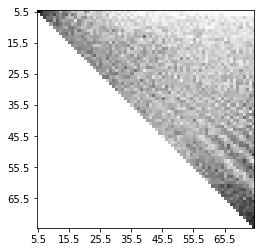

In [17]:
relation(50)